In [ ]:
# 필요한 라이브러리 설치
!pip install torch torchvision
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
!apt-get install -y bullet
!pip install pybullet
!pip install opencv-python-headless matplotlib numpy
!pip install ultralytics

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-gxpdya4_
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-gxpdya4_
  Resolved https://github.com/facebookresearch/detectron2.git to commit 9604f5995cc628619f0e4fd913453b4d7d61db3f
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.2/79.2 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 52.2 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp3

In [ ]:
import cv2
import numpy as np
import torch
import pybullet as p
import matplotlib.pyplot as plt
from ultralytics import YOLO
import matplotlib.font_manager as fm
import platform

# ---- 1. 한글 폰트 설정 ----
if platform.system() == 'Windows':
    font_path = "C:/Windows/Fonts/malgun.ttf"  # Windows 기본 폰트
elif platform.system() == 'Darwin':
    font_path = "/Library/Fonts/AppleGothic.ttf"  # MacOS 기본 폰트
else:
    !sudo apt-get install -y fonts-nanum
    !fc-cache -fv
    font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"  # Colab 또는 Linux

fontprop = fm.FontProperties(fname=font_path)
plt.rc('font', family=fontprop.get_name())

# ---- 2. YOLO 모델 로드 ----
def detect_balls_with_yolo(image_path):
    model = YOLO('yolov8n.pt')  # YOLOv8 Nano model (가벼운 모델)
    results = model(image_path)
    detections = results[0].boxes.xyxy.cpu().numpy()  # 탐지된 공 좌표 (x1, y1, x2, y2)
    return detections

# ---- 3. 물리 시뮬레이션 ----
def simulate_shot(cue_ball, target_ball_1, cushion_count=2):
    p.connect(p.DIRECT)  # 물리 시뮬레이터 초기화
    p.setGravity(0, 0, -10)  # 중력 설정

    cue_ball_pos = np.array(cue_ball[:2])
    target_1_pos = np.array(target_ball_1[:2])

    cue_ball_id = p.createCollisionShape(p.GEOM_SPHERE, radius=0.028)
    p.createMultiBody(0.17, cue_ball_id, basePosition=cue_ball_pos.tolist())

    for _ in range(240):
        p.stepSimulation()
        if is_collision(cue_ball_pos, target_1_pos):
            print("첫 번째 목표 공을 향해 치세요!")
            break
    p.disconnect()

# 충돌 확인
def is_collision(pos1, pos2, threshold=0.03):
    return np.linalg.norm(np.array(pos1) - np.array(pos2)) < threshold

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (6,174 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling bac

In [ ]:
# ---- 4. 명중 지점 시각화 ----
def show_hit_point_with_trajectory(image, cue_ball, target_1, target_2=None):
    cue_x, cue_y = (cue_ball[0] + cue_ball[2]) / 2, (cue_ball[1] + cue_ball[3]) / 2
    target1_x, target1_y = (target_1[0] + target_1[2]) / 2, (target_1[1] + target_1[3]) / 2

    trajectory = [(cue_x, cue_y), (target1_x, target1_y)]
    if target_2 is not None:
        target2_x, target2_y = (target_2[0] + target_2[2]) / 2, (target_2[1] + target_2[3]) / 2
        trajectory.append((target2_x, target2_y))

    marked_image = image.copy()
    for point in trajectory:
        cv2.circle(marked_image, tuple(map(int, point)), 10, (255, 0, 0), -1)

    direction = np.array([target1_x - cue_x, target1_y - cue_y])
    direction = direction / np.linalg.norm(direction)
    hit_x = cue_x + direction[0] * 10
    hit_y = cue_y + direction[1] * 10
    cv2.circle(marked_image, (int(hit_x), int(hit_y)), 5, (255, 0, 0), -1)
    cv2.putText(marked_image, "Hit Here", (int(hit_x) + 10, int(hit_y) - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(marked_image, cv2.COLOR_BGR2RGB))
    plt.title("당구공 궤적과 명중 지점", fontproperties=fontprop)
    plt.axis('off')
    plt.show()

100%|██████████| 6.25M/6.25M [00:00<00:00, 108MB/s]



image 1/1 /content/drive/MyDrive/Aiffelthon/ModelTest/Data/Three-Ball_Billiards/success04_mp4-0008_jpg.rf.d60e12eb85771318f182477e8bb5c81a.jpg: 384x640 1 person, 2 sports balls, 1 tv, 119.6ms
Speed: 14.4ms preprocess, 119.6ms inference, 847.7ms postprocess per image at shape (1, 3, 384, 640)


감지된 공 좌표: [[     1603.7      414.51      1919.2      687.03]
 [     114.65       110.1        1605      819.83]
 [     940.98      447.74      971.56      475.88]
 [       1179         615      1209.3      640.97]]


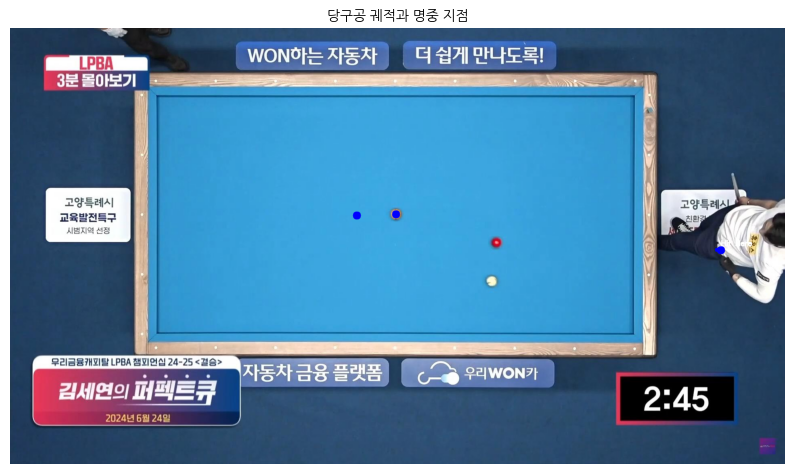

In [ ]:
# ---- 5. 프로그램 실행 ----
def main():
    image_path = "/content/drive/MyDrive/Aiffelthon/ModelTest/Data/Three-Ball_Billiards/success04_mp4-0008_jpg.rf.d60e12eb85771318f182477e8bb5c81a.jpg"
    balls = detect_balls_with_yolo(image_path)
    print("감지된 공 좌표:", balls)

    if len(balls) < 2:
        print("공의 위치 정보가 부족합니다.")
        return

    cue_ball, target_ball_1 = balls[0], balls[1]
    target_ball_2 = balls[2] if len(balls) > 2 else None

    simulate_shot(cue_ball, target_ball_1)
    show_hit_point_with_trajectory(cv2.imread(image_path), cue_ball, target_ball_1, target_ball_2)

main()